# Introduction

##The objective of this project is to perform text classification on a dataset containing news headlines and bodies to distinguish between real and fake news. The code implements various natural language processing (NLP), deep learning and machine learning techniques to achieve this goal.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

%cd /content/gdrive/MyDrive/Datamining


Mounted at /content/gdrive
/content/gdrive/MyDrive/Datamining


# Step 1: Data Preprocessing
* Import the necessary libraries and modules.
* Load the dataset from a CSV file and drop rows with missing values.*
* Visualize the distribution of labels (real vs. fake news) using a countplot.


In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import Counter
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from textblob import TextBlob
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences



nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv("data.csv")
df = df.dropna()
df.head(5)

,URLs,Headline,Body,Label
0,http://www.bbc.com/news/world-us-canada-414191...,Four ways Bob Corker skewered Donald Trump,Image copyright Getty Images\nOn Sunday mornin...,1
1,https://www.reuters.com/article/us-filmfestiva...,Linklater's war veteran comedy speaks to moder...,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,https://www.nytimes.com/2017/10/09/us/politics...,Trump’s Fight With Corker Jeopardizes His Legi...,The feud broke into public view last week when...,1
3,https://www.reuters.com/article/us-mexico-oil-...,Egypt's Cheiron wins tie-up with Pemex for Mex...,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,http://www.cnn.com/videos/cnnmoney/2017/10/08/...,Jason Aldean opens 'SNL' with Vegas tribute,"Country singer Jason Aldean, who was performin...",1


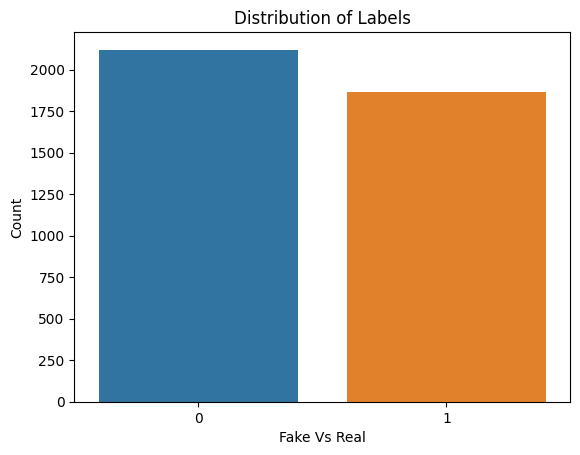

In [ ]:
sns.countplot(data=df, x='Label')
plt.xlabel('Fake Vs Real')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()


In [ ]:
df['Headline_Length'] = df['Headline'].apply(len)
avg_headline_length = df.groupby('Label')['Headline_Length'].mean()
print(avg_headline_length)


Label
0    62.473585
1    57.311028
Name: Headline_Length, dtype: float64


# Step 2: Text Preprocessing / Data Mining
* Define a function preprocess_text to clean and preprocess the text data:
* Convert text to lowercase.
* Remove non-alphabetic characters.
* Tokenize the text.
* Stem words using Porter stemming.
* Remove stopwords and punctuation.
* Apply the preprocess_text function to both headlines and body text in the dataset to obtain cleaned text.


In [ ]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()

        text = re.sub(r'[^a-zA-Z\s]', '', text)

        words = word_tokenize(text)

        stemmed_words = [stemmer.stem(word) for word in words if word not in stop_words and word not in string.punctuation]

        cleaned_text = ' '.join(stemmed_words)
        return cleaned_text
    else:
        return ''


df['cleaned_headlines'] = df['Headline'].apply(preprocess_text)
df['cleaned_bodies'] = df['Body'].apply(preprocess_text)



#Step 3: Exploratory Data Analysis (EDA)
* Create word clouds for headlines and body text to visualize the most frequent words.

* Identify the most common words in real and fake news headlines and body text using a bar plot.

* Extract website information from URLs and analyze common websites associated with each label (real vs. fake news).

* Applying Sentiment Analysis using TextBlob.





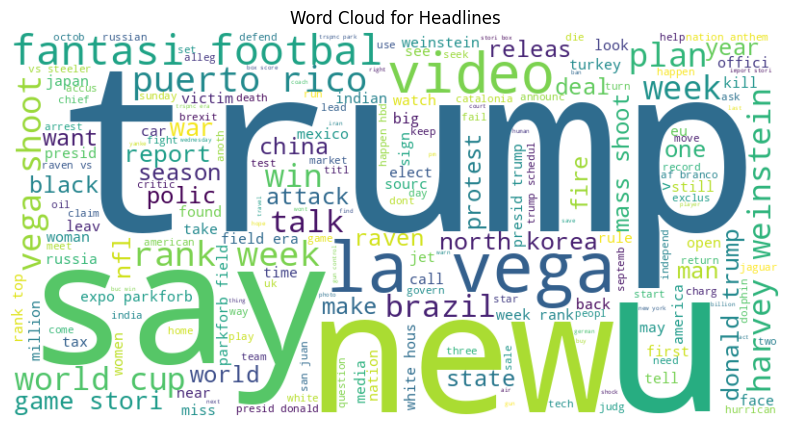

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_headlines']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Headlines')
plt.show()


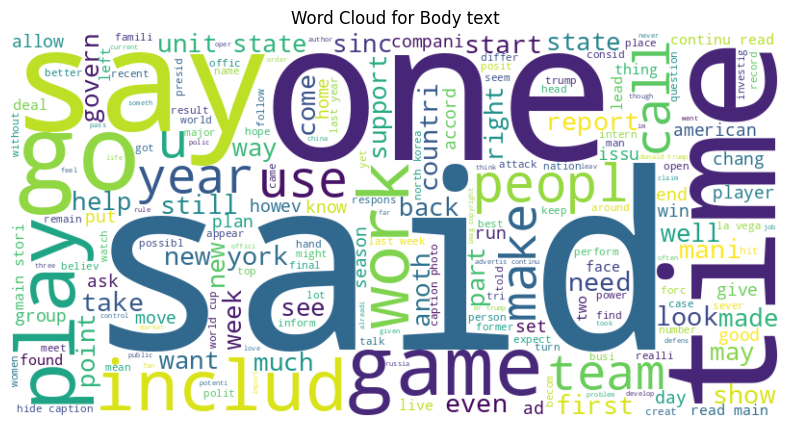

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_bodies']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Body text')
plt.show()


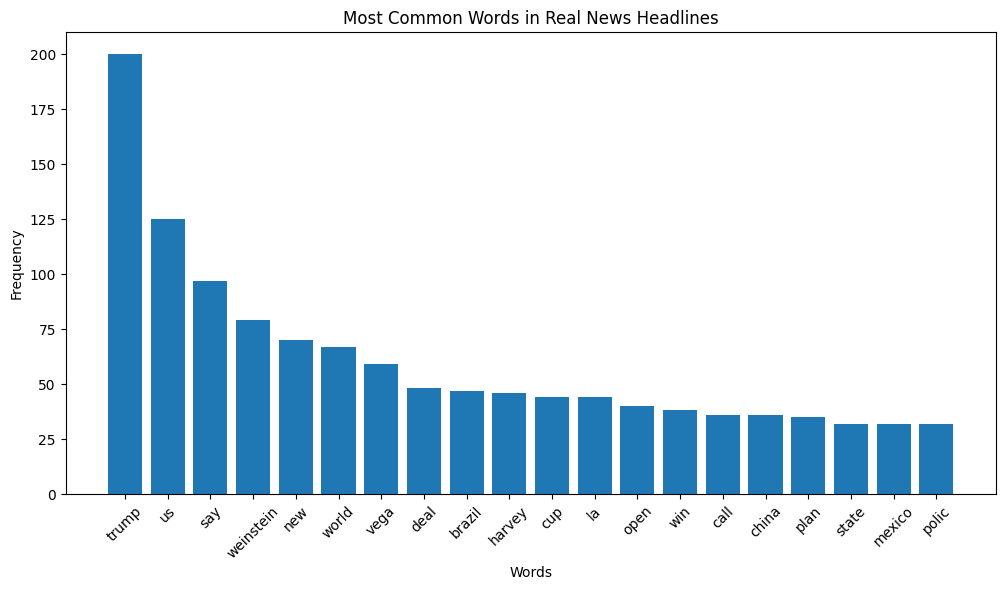

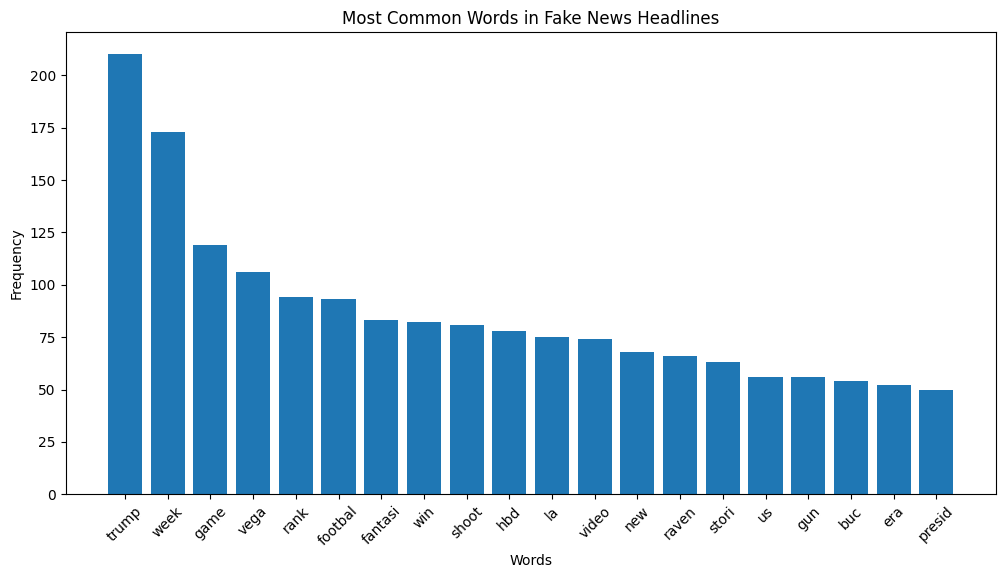

In [ ]:
real_news_df = df[df['Label'] == 1]
fake_news_df = df[df['Label'] == 0]

def word_plot(data, title):
    words = ' '.join(data).split()
    word_freq = Counter(words)

    common_words = word_freq.most_common(20)
    words, freq = zip(*common_words)

    plt.figure(figsize=(12, 6))
    plt.bar(words, freq)
    plt.xticks(rotation=45)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

word_plot(real_news_df['cleaned_headlines'], 'Most Common Words in Real News Headlines')

word_plot(fake_news_df['cleaned_headlines'], 'Most Common Words in Fake News Headlines')


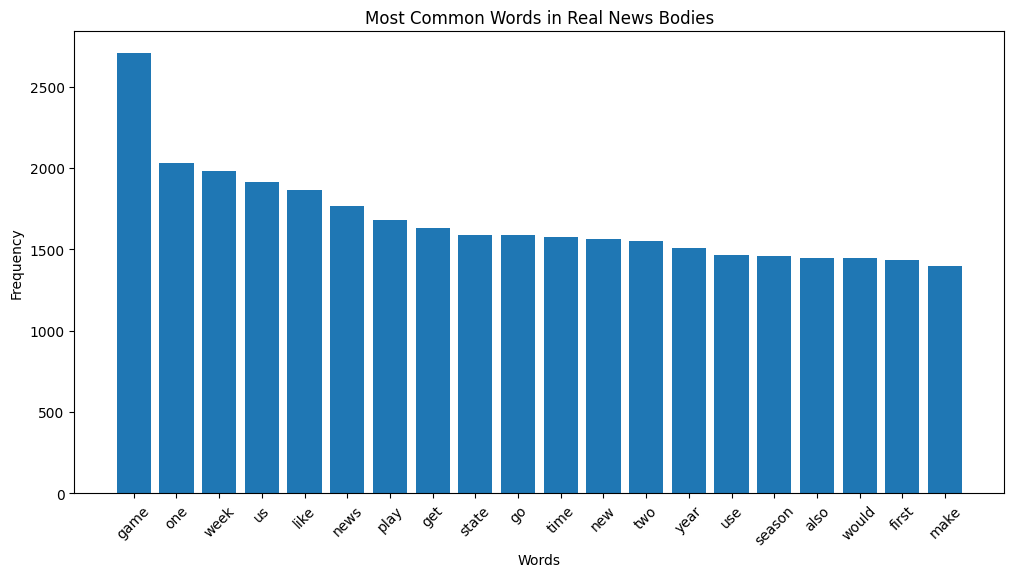

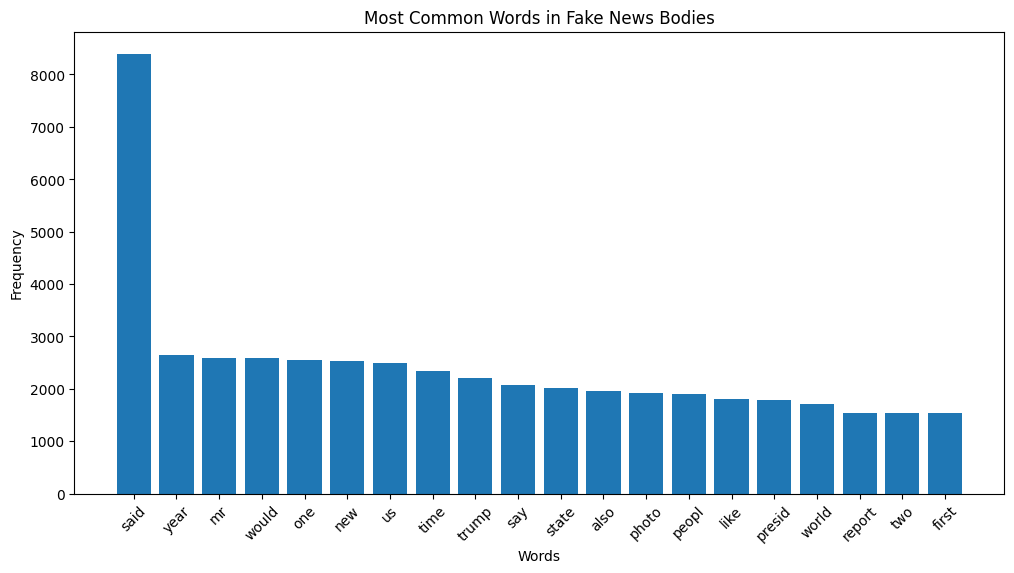

In [ ]:
word_plot(fake_news_df['cleaned_bodies'], 'Most Common Words in Real News Bodies')

word_plot(real_news_df['cleaned_bodies'], 'Most Common Words in Fake News Bodies')


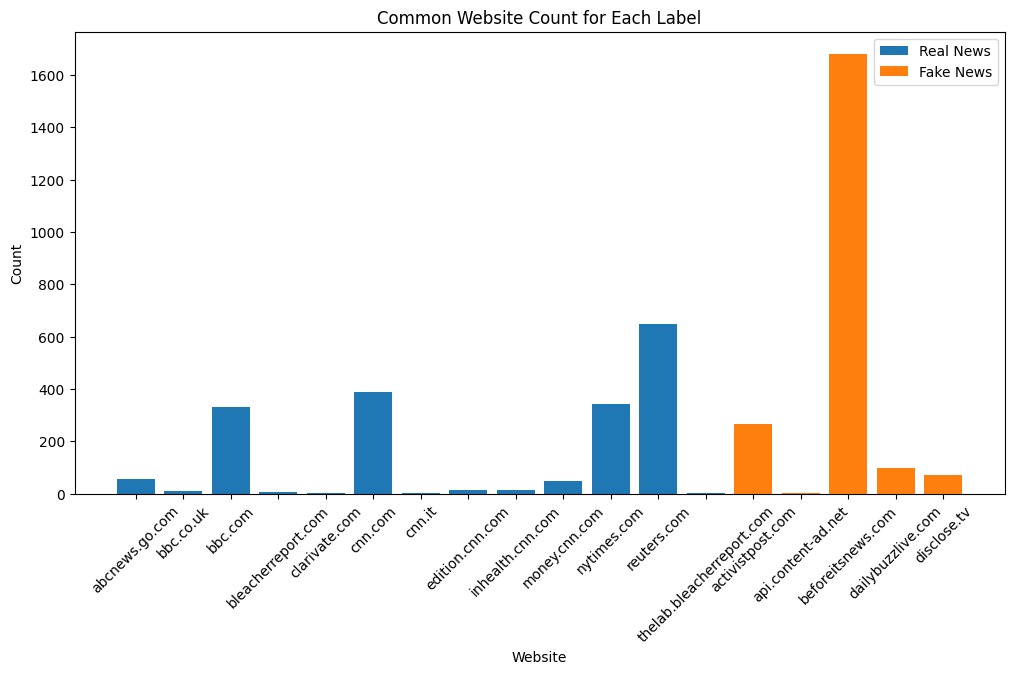

In [ ]:
df['Website'] = df['URLs'].str.extract(r'(https?://(www\.)?([^/]+))')[2]

website_counts = df.groupby(['Label', 'Website']).size().reset_index(name='Count')

fake_counts = website_counts[website_counts['Label'] == 0]
real_counts = website_counts[website_counts['Label'] == 1]

plt.figure(figsize=(12, 6))
plt.bar(real_counts['Website'], real_counts['Count'], label='Real News')
plt.bar(fake_counts['Website'], fake_counts['Count'], label='Fake News')
plt.xticks(rotation=45)
plt.xlabel('Website')
plt.ylabel('Count')
plt.title('Common Website Count for Each Label')
plt.legend()
plt.show()


In [ ]:
#sentiment analysis fake news vs real news
df['polarity'] = df['cleaned_bodies'].apply(lambda text: TextBlob(text).sentiment.polarity)
df['subjectivity'] = df['cleaned_bodies'].apply(lambda text: TextBlob(text).sentiment.subjectivity)

sentiment_analysis = df.groupby('Label').agg({
    'polarity': 'mean',
    'subjectivity': 'mean'
}).reset_index()

sentiment_analysis['Label'] = sentiment_analysis['Label'].map({0: 'Fake News', 1: 'Real News'})


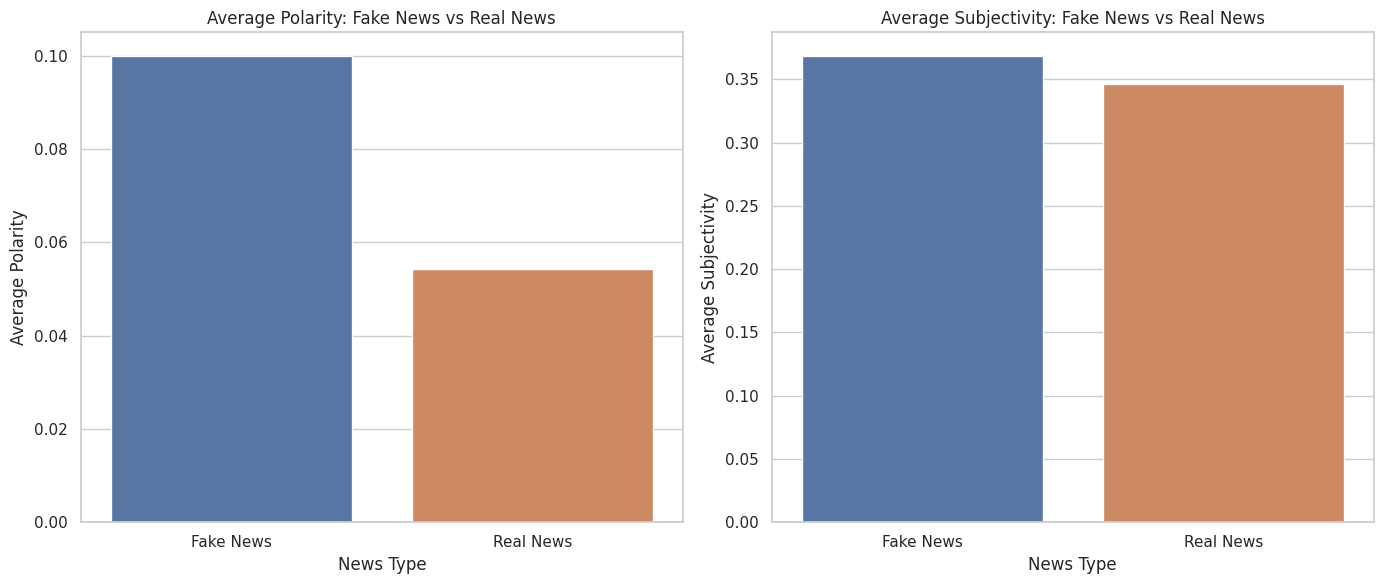

In [ ]:
#Bar Plot for Average Polarity and Subjectivity

sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x='Label', y='polarity', data=sentiment_analysis, ax=axes[0])
axes[0].set_title('Average Polarity: Fake News vs Real News')
axes[0].set_ylabel('Average Polarity')
axes[0].set_xlabel('News Type')

sns.barplot(x='Label', y='subjectivity', data=sentiment_analysis, ax=axes[1])
axes[1].set_title('Average Subjectivity: Fake News vs Real News')
axes[1].set_ylabel('Average Subjectivity')
axes[1].set_xlabel('News Type')

plt.tight_layout()
plt.show()


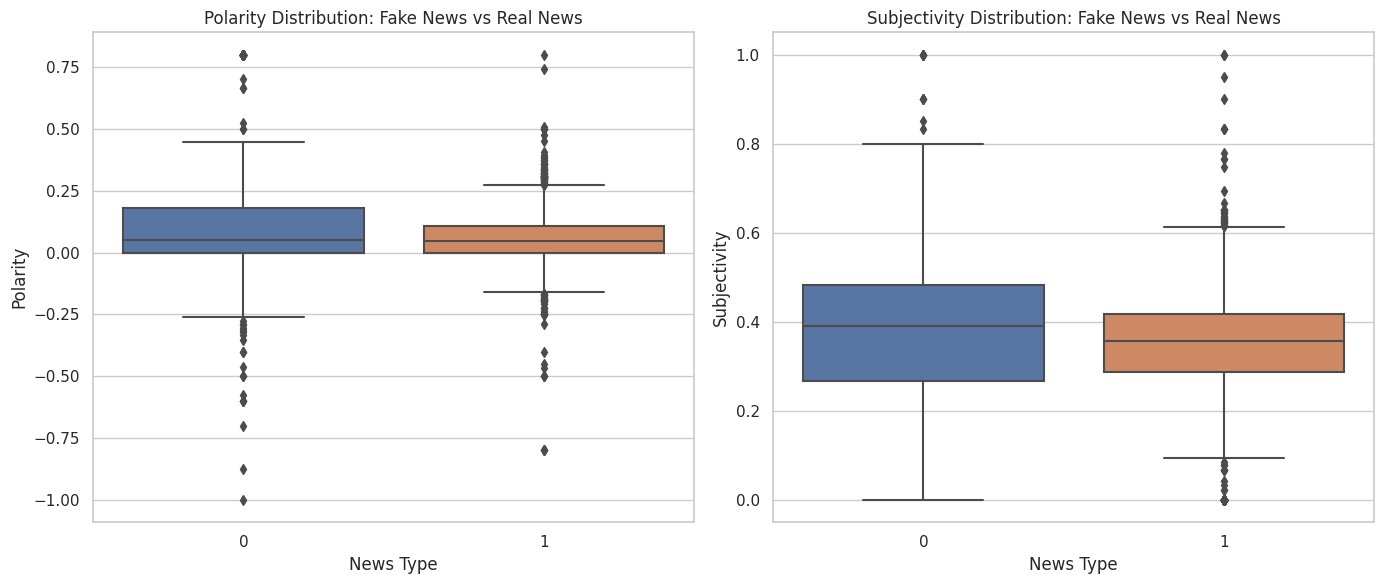

In [ ]:
#Box Plot for Polarity and Subjectivity Distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x='Label', y='polarity', data=df, ax=axes[0])
axes[0].set_title('Polarity Distribution: Fake News vs Real News')
axes[0].set_ylabel('Polarity')
axes[0].set_xlabel('News Type')

sns.boxplot(x='Label', y='subjectivity', data=df, ax=axes[1])
axes[1].set_title('Subjectivity Distribution: Fake News vs Real News')
axes[1].set_ylabel('Subjectivity')
axes[1].set_xlabel('News Type')

plt.tight_layout()
plt.show()


#Step 4: Feature Engineering
* Perform TF-IDF (Term Frequency-Inverse Document Frequency) vectorization on the cleaned headlines and body text to convert text data into numerical features.
* apply SVD (Singular Value Decomposition) to the TF-IDF matrix to reduce its dimensionality and extract latent semantic information to use with the deep learning models.

* Split the dataset into training and validation sets for both headlines and body text.


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_hl = tfidf_vectorizer.fit_transform(df['cleaned_headlines'])
x_bd = tfidf_vectorizer.fit_transform(df['cleaned_bodies'])

df['headline_length'] = df['cleaned_headlines'].apply(len)
df['body_length'] = df['cleaned_bodies'].apply(len)



In [ ]:

tfidf_hl = TfidfVectorizer(max_features=5000)
X_hl = tfidf_hl.fit_transform(df['cleaned_headlines'])

tfidf_bd = TfidfVectorizer(max_features=5000)
x_bd = tfidf_bd.fit_transform(df['cleaned_bodies'])


svd_hl = TruncatedSVD(n_components=90)  #Latent Semantic Analysis
svd_bd = TruncatedSVD(n_components=150)

X_hl_train, X_hl_test, y_hl_train, y_hl_test = train_test_split(X_hl, df['Label'], test_size=0.2, random_state=3, stratify=df['Label'])

x_bd_train, x_bd_test, y_bd_train, y_bd_test = train_test_split(x_bd, df['Label'], test_size=0.2, random_state=3, stratify=df['Label'])

X_hl_svd = svd_hl.fit_transform(X_hl)
X_bd_svd = svd_bd.fit_transform(x_bd)

X_hl_train_svd, X_hl_test_svd, y_hl_train_svd, y_hl_test_svd = train_test_split(X_hl_svd, df['Label'], test_size=0.2, random_state=3, stratify=df['Label'])

x_bd_train_svd, x_bd_test_svd, y_bd_train_svd, y_bd_test_svd = train_test_split(X_bd_svd, df['Label'], test_size=0.2, random_state=3, stratify=df['Label'])



In [ ]:
print("Explained variance for headlines:", svd_hl.explained_variance_ratio_.sum())
print("Explained variance for bodies:", svd_bd.explained_variance_ratio_.sum())


Explained variance for headlines: 0.21313387498108805
Explained variance for bodies: 0.487906326563803


#Step 5: Model Building and Evaluation


* Train and evaluate multiple machine learning models, including:

  * Naive Bayes (NB)
  * K-Nearest Neighbors (KNN)
  * Multi-layer Perceptron (MLP)
  * Recurrent Neural Network (RNN)

For fake news detection we consider supervised statistical methods.
* Calculate and append the classification report and accuracy score

* Visualize the confusion matrices for each model to assess the true positives, true negatives, false positives, and false negatives.



In [ ]:
reports = []
models = []


def plot_cm(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    plt.show()



In [ ]:
logistic_hl = LogisticRegression() #by default L2 penalty term is applied (regularization term of Ridge Regression)
logistic_hl.fit(X_hl_train, y_hl_train)

y_hl_pred = logistic_hl.predict(X_hl_test)

logistic_bd = LogisticRegression()
logistic_bd.fit(x_bd_train, y_bd_train)

y_bd_pred = logistic_bd.predict(x_bd_test)


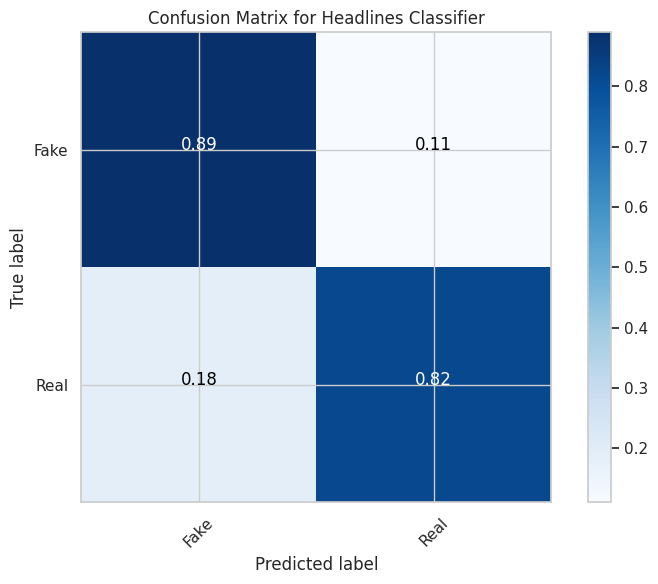

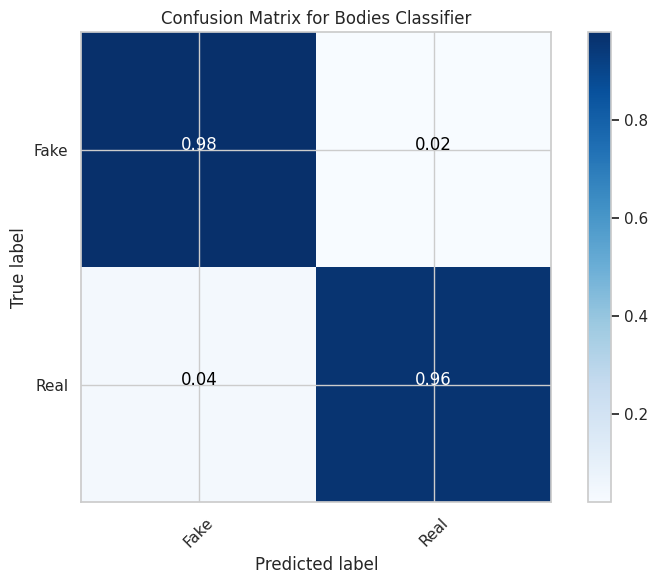

In [ ]:
logistic_hl_report = classification_report(y_hl_test, y_hl_pred) # the accuracy of the model is obtained by comparing the predicted values (y_hl_pred) with the actual values (y_hl_test)
logistic_hl_accuracy = accuracy_score(y_hl_test, y_hl_pred)
reports.append(f"Logistic Regression (Headlines)\nAccuracy: {logistic_hl_accuracy:.2f}\n\n{logistic_hl_report}")
models.append("Logistic Regression (Headlines)")


logistic_bd_report = classification_report(y_bd_test, y_bd_pred)
logistic_bd_accuracy = accuracy_score(y_bd_test, y_bd_pred)
reports.append(f"Logistic Regression (Bodies)\nAccuracy: {logistic_bd_accuracy:.2f}\n\n{logistic_bd_report}")
models.append("Logistic Regression (Bodies)")


plot_cm(y_hl_test, y_hl_pred, classes=['Fake', 'Real'], normalize=True, title='Confusion Matrix for Headlines Classifier')
plot_cm(y_bd_test, y_bd_pred, classes=['Fake', 'Real'], normalize=True, title='Confusion Matrix for Bodies Classifier')

plt.show()


In [ ]:
nb_hl = MultinomialNB()
nb_hl.fit(X_hl_train, y_hl_train)

y_hl_pred = nb_hl.predict(X_hl_test)

nb_bd = MultinomialNB()
nb_bd.fit(x_bd_train, y_bd_train)

y_bd_pred = nb_bd.predict(x_bd_test)


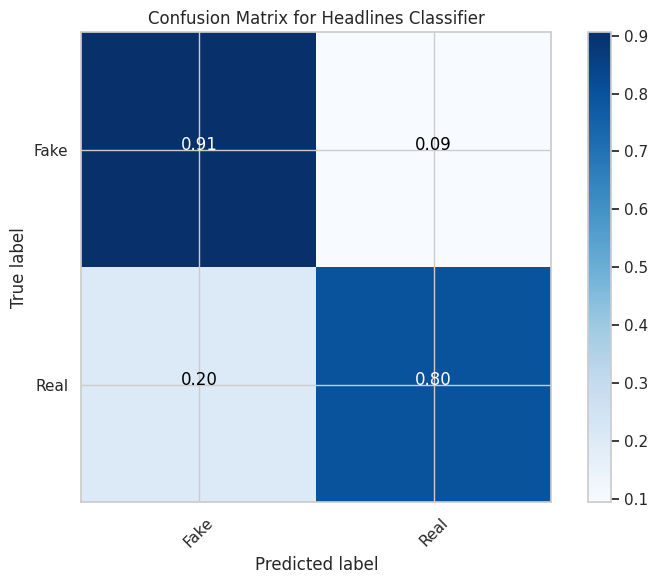

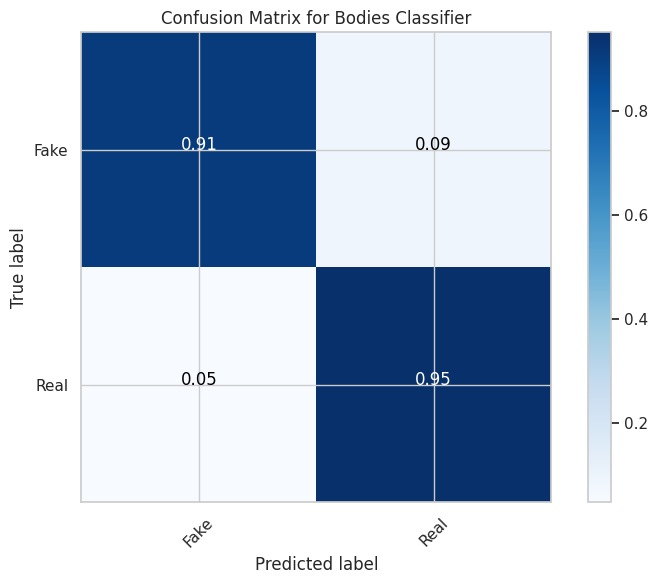

In [ ]:
nb_hl_report = classification_report(y_hl_test, y_hl_pred)
nb_hl_accuracy = accuracy_score(y_hl_test, y_hl_pred)
reports.append(f"Naive Bayes (Headlines)\nAccuracy: {nb_hl_accuracy:.2f}\n\n{nb_hl_report}")
models.append("Naive Bayes (Headlines)")

nb_bd_report = classification_report(y_bd_test, y_bd_pred)
nb_bd_accuracy = accuracy_score(y_bd_test, y_bd_pred)
reports.append(f"Naive Bayes (Bodies)\nAccuracy: {nb_bd_accuracy:.2f}\n\n{nb_bd_report}")
models.append("Naive Bayes (Bodies)")

plot_cm(y_hl_test, y_hl_pred, classes=['Fake', 'Real'], normalize=True, title='Confusion Matrix for Headlines Classifier')
plot_cm(y_bd_test, y_bd_pred, classes=['Fake', 'Real'], normalize=True, title='Confusion Matrix for Bodies Classifier')


In [ ]:
knn_hl = KNeighborsClassifier(n_neighbors=5) #number of neighbors 5 worked best for headlines
                                             #by default all points in each neighborhood are weighted equally
                                             #default metric is “minkowski”, which results in the standard Euclidean distance when p = 2
knn_hl.fit(X_hl_train, y_hl_train)

y_hl_pred_knn = knn_hl.predict(X_hl_test)


knn_bodies = KNeighborsClassifier(n_neighbors=13) #number of neighbors 13 worked best for bodies
knn_bodies.fit(x_bd_train, y_bd_train)

y_bd_pred_knn = knn_bodies.predict(x_bd_test)


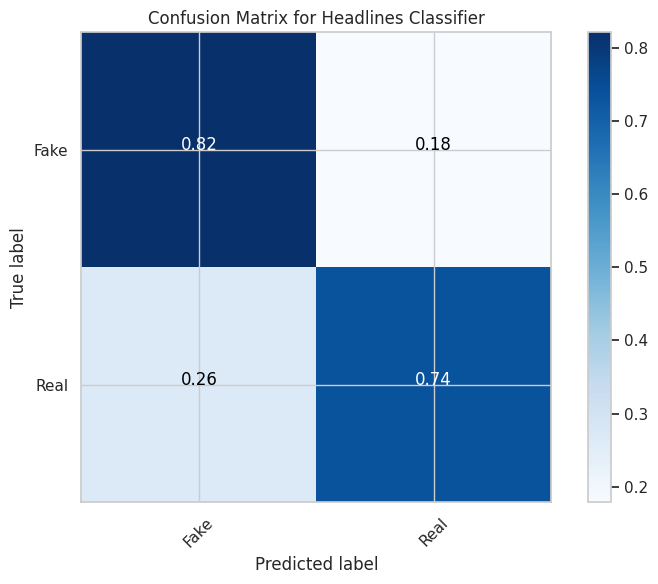

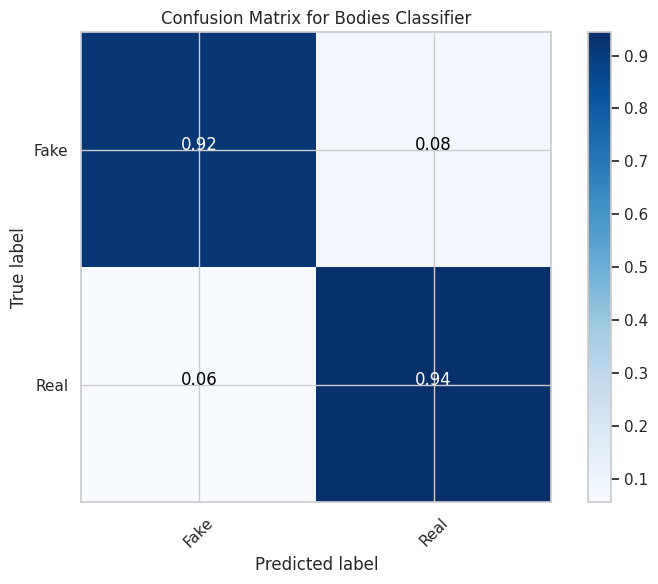

In [ ]:
knn_hl_report = classification_report(y_hl_test, y_hl_pred_knn)
knn_hl_accuracy = accuracy_score(y_hl_test, y_hl_pred_knn)
reports.append(f"KNN (Headlines)\nAccuracy: {knn_hl_accuracy:.2f}\n\n{knn_hl_report}")
models.append("KNN (Headlines)")

knn_bd_report = classification_report(y_bd_test, y_bd_pred_knn)
knn_bd_accuracy = accuracy_score(y_bd_test, y_bd_pred_knn)
reports.append(f"KNN (Bodies)\nAccuracy: {knn_bd_accuracy:.2f}\n\n{knn_bd_report}")
models.append("KNN (Bodies)")


confusion_matriX_hl_knn = confusion_matrix(y_hl_test, y_hl_pred_knn)
confusion_matrix_bd_knn = confusion_matrix(y_bd_test, y_bd_pred_knn)

plot_cm(y_hl_test, y_hl_pred_knn, classes=['Fake', 'Real'], normalize=True, title='Confusion Matrix for Headlines Classifier')
plot_cm(y_bd_test, y_bd_pred_knn, classes=['Fake', 'Real'], normalize=True, title='Confusion Matrix for Bodies Classifier')


In [ ]:
def mlp_trainer(input_dim):
    model = Sequential()
    model.add(Dense(80, input_dim=input_dim.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


mlp_headlines = mlp_trainer(X_hl_train_svd)
mlp_bodies = mlp_trainer(x_bd_train_svd)



In [ ]:
mlp_headlines.fit(X_hl_train_svd, y_hl_train_svd, epochs=15, batch_size=32, validation_data=(X_hl_test_svd, y_hl_test_svd), callbacks=[early_stopping])



Epoch 1/15
100/100 [==============================] - 2s 6ms/step - loss: 0.6643 - accuracy: 0.5567 - val_loss: 0.6029 - val_accuracy: 0.7393
Epoch 2/15
100/100 [==============================] - 0s 3ms/step - loss: 0.5572 - accuracy: 0.7132 - val_loss: 0.4999 - val_accuracy: 0.7619
Epoch 3/15
100/100 [==============================] - 0s 3ms/step - loss: 0.5054 - accuracy: 0.7436 - val_loss: 0.4764 - val_accuracy: 0.7682
Epoch 4/15
100/100 [==============================] - 0s 4ms/step - loss: 0.4700 - accuracy: 0.7614 - val_loss: 0.4586 - val_accuracy: 0.7782
Epoch 5/15
100/100 [==============================] - 0s 4ms/step - loss: 0.4482 - accuracy: 0.7856 - val_loss: 0.4402 - val_accuracy: 0.7895
Epoch 6/15
100/100 [==============================] - 0s 4ms/step - loss: 0.4314 - accuracy: 0.7897 - val_loss: 0.4373 - val_accuracy: 0.7870
Epoch 7/15
100/100 [==============================] - 0s 3ms/step - loss: 0.4058 - accuracy: 0.8066 - val_loss: 0.4289 - val_accuracy: 0.7769
Epoch 

In [ ]:
mlp_bodies.fit(x_bd_train_svd, y_bd_train_svd, epochs=30, batch_size=32, validation_data=(x_bd_test_svd, y_bd_test_svd), callbacks=[early_stopping])


Epoch 1/30
100/100 [==============================] - 2s 5ms/step - loss: 0.5626 - accuracy: 0.6843 - val_loss: 0.2039 - val_accuracy: 0.9461
Epoch 2/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1714 - accuracy: 0.9304 - val_loss: 0.1151 - val_accuracy: 0.9549
Epoch 3/30
100/100 [==============================] - 0s 3ms/step - loss: 0.1042 - accuracy: 0.9643 - val_loss: 0.0683 - val_accuracy: 0.9774
Epoch 4/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0815 - accuracy: 0.9718 - val_loss: 0.0752 - val_accuracy: 0.9699
Epoch 5/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0667 - accuracy: 0.9749 - val_loss: 0.0634 - val_accuracy: 0.9774
Epoch 6/30
100/100 [==============================] - 0s 3ms/step - loss: 0.0624 - accuracy: 0.9774 - val_loss: 0.0687 - val_accuracy: 0.9762
Epoch 7/30
100/100 [==============================] - 0s 4ms/step - loss: 0.0521 - accuracy: 0.9834 - val_loss: 0.0643 - val_accuracy: 0.9774
Epoch 

25/25 [==============================] - 0s 2ms/step


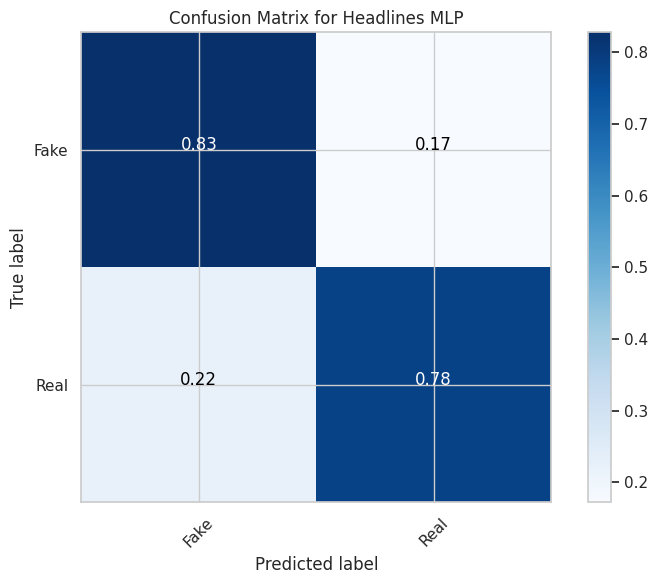

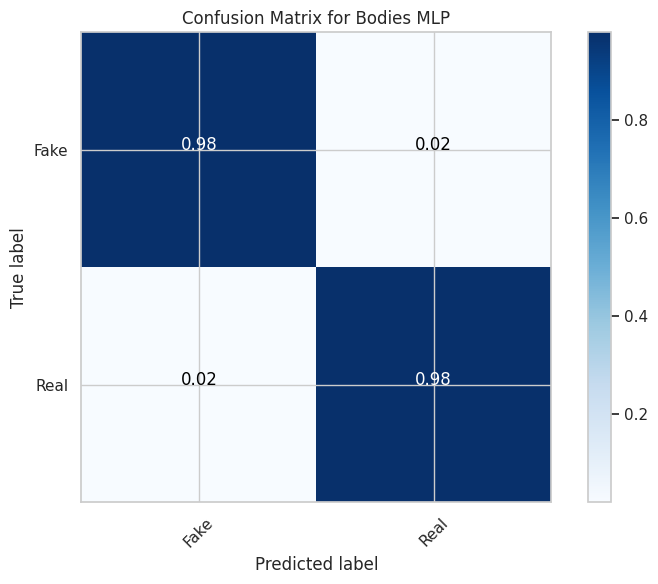

In [ ]:
y_hl_pred_mlp = mlp_headlines.predict(X_hl_test_svd)
y_hl_pred_mlp = (y_hl_pred_mlp > 0.5).astype(int)

y_bd_pred_mlp = mlp_bodies.predict(x_bd_test_svd)
y_bd_pred_mlp = (y_bd_pred_mlp > 0.5).astype(int)

mlp_hl_accuracy = accuracy_score(y_hl_test, y_hl_pred_mlp)
mlp_hl_report = classification_report(y_hl_test, y_hl_pred_mlp)
reports.append(f"MLP (Headlines)\nAccuracy: {mlp_hl_accuracy:.2f}\n\n{mlp_hl_report}")
models.append("MLP (Headlines)")

mlp_bd_accuracy = accuracy_score(y_bd_test, y_bd_pred_mlp)
mlp_bd_report = classification_report(y_bd_test, y_bd_pred_mlp)
reports.append(f"MLP (Bodies)\nAccuracy: {mlp_bd_accuracy:.2f}\n\n{mlp_bd_report}")
models.append("MLP (Bodies)")


plot_cm(y_hl_test, y_hl_pred_mlp, classes=['Fake', 'Real'], normalize=True, title='Confusion Matrix for Headlines MLP')
plot_cm(y_bd_test, y_bd_pred_mlp, classes=['Fake', 'Real'], normalize=True, title='Confusion Matrix for Bodies MLP')


In [ ]:

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

tokenizer_hl = Tokenizer(num_words=5000)
tokenizer_hl.fit_on_texts(df_train['cleaned_headlines'])

X_headlines_train_seq = tokenizer_hl.texts_to_sequences(df_train['cleaned_headlines'])
X_headlines_train_padded = pad_sequences(X_headlines_train_seq, maxlen=100)

X_headlines_test_seq = tokenizer_hl.texts_to_sequences(df_test['cleaned_headlines'])
X_headlines_test_padded = pad_sequences(X_headlines_test_seq, maxlen=100)

tokenizer_bd = Tokenizer(num_words=5000)
tokenizer_bd.fit_on_texts(df_train['cleaned_bodies'])

X_bodies_train_seq = tokenizer_bd.texts_to_sequences(df_train['cleaned_bodies'])
X_bodies_train_padded = pad_sequences(X_bodies_train_seq, maxlen=100)

X_bodies_test_seq = tokenizer_bd.texts_to_sequences(df_test['cleaned_bodies'])
X_bodies_test_padded = pad_sequences(X_bodies_test_seq, maxlen=100)



In [ ]:
def lstm_trainer(input_dim):
    model = Sequential()
    model.add(Embedding(input_dim, 128, input_length=100))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_headlines = lstm_trainer(len(tokenizer_hl.word_index) + 1)
lstm_bodies = lstm_trainer(len(tokenizer_bd.word_index) + 1)




In [ ]:
lstm_headlines.fit(X_headlines_train_padded, df_train['Label'], epochs=15, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/15
80/80 [==============================] - 12s 94ms/step - loss: 0.6511 - accuracy: 0.6328 - val_loss: 0.4965 - val_accuracy: 0.7790
Epoch 2/15
80/80 [==============================] - 7s 87ms/step - loss: 0.3082 - accuracy: 0.8868 - val_loss: 0.3633 - val_accuracy: 0.8339
Epoch 3/15
80/80 [==============================] - 8s 101ms/step - loss: 0.1089 - accuracy: 0.9651 - val_loss: 0.4028 - val_accuracy: 0.8464
Epoch 4/15
80/80 [==============================] - 8s 105ms/step - loss: 0.0396 - accuracy: 0.9886 - val_loss: 0.5057 - val_accuracy: 0.8417
Epoch 5/15
80/80 [==============================] - 11s 132ms/step - loss: 0.0179 - accuracy: 0.9953 - val_loss: 0.5818 - val_accuracy: 0.8354
Epoch 6/15
80/80 [==============================] - 6s 81ms/step - loss: 0.0099 - accuracy: 0.9984 - val_loss: 0.6483 - val_accuracy: 0.8433
Epoch 7/15
80/80 [==============================] - 9s 113ms/step - loss: 0.1945 - accuracy: 0.9698 - val_loss: 0.5219 - val_accuracy: 0.8354


In [ ]:
lstm_bodies.fit(X_bodies_train_padded, df_train['Label'], epochs=15, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/15
80/80 [==============================] - 16s 153ms/step - loss: 0.3501 - accuracy: 0.8499 - val_loss: 0.1443 - val_accuracy: 0.9483
Epoch 2/15
80/80 [==============================] - 13s 165ms/step - loss: 0.0478 - accuracy: 0.9875 - val_loss: 0.0638 - val_accuracy: 0.9796
Epoch 3/15
80/80 [==============================] - 13s 162ms/step - loss: 0.0156 - accuracy: 0.9980 - val_loss: 0.0822 - val_accuracy: 0.9687
Epoch 4/15
80/80 [==============================] - 11s 138ms/step - loss: 0.0075 - accuracy: 0.9992 - val_loss: 0.0915 - val_accuracy: 0.9702
Epoch 5/15
80/80 [==============================] - 12s 153ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0770 - val_accuracy: 0.9718
Epoch 6/15
80/80 [==============================] - 13s 167ms/step - loss: 9.4300e-04 - accuracy: 1.0000 - val_loss: 0.1012 - val_accuracy: 0.9749
Epoch 7/15
80/80 [==============================] - 12s 154ms/step - loss: 6.5500e-04 - accuracy: 1.0000 - val_loss: 0.1080 - val_accuracy

25/25 [==============================] - 1s 41ms/step


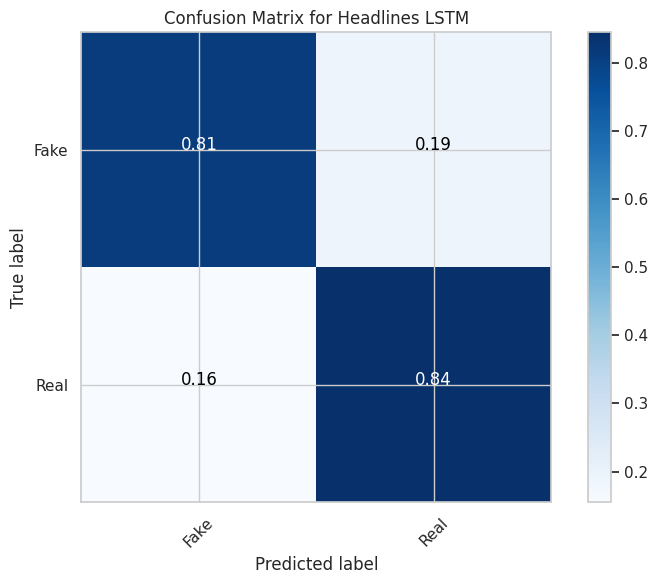

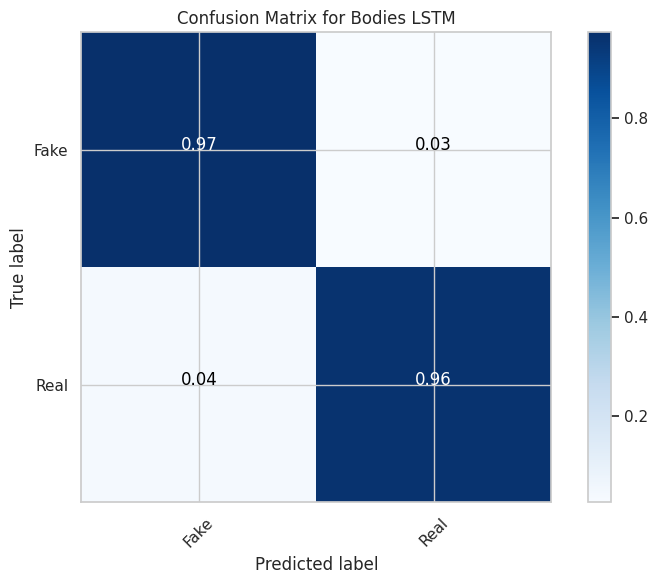

In [ ]:
y_headlines_test = df_test['Label']
y_headlines_pred_lstm = (lstm_headlines.predict(X_headlines_test_padded) > 0.5).astype(int)
lstm_headlines_accuracy = accuracy_score(y_headlines_test, y_headlines_pred_lstm)
lstm_headlines_report = classification_report(y_headlines_test, y_headlines_pred_lstm)

y_bodies_test = df_test['Label']
y_bodies_pred_lstm = (lstm_bodies.predict(X_bodies_test_padded) > 0.5).astype(int)
lstm_bodies_accuracy = accuracy_score(y_bodies_test, y_bodies_pred_lstm)
lstm_bodies_report = classification_report(y_bodies_test, y_bodies_pred_lstm)


reports.append(f"LSTM (Headlines)\nAccuracy: {lstm_headlines_accuracy:.2f}\n\n{lstm_headlines_report}")
models.append("LSTM (Headlines)")

reports.append(f"LSTM (Bodies)\nAccuracy: {lstm_bodies_accuracy:.2f}\n\n{lstm_bodies_report}")
models.append("LSTM (Bodies)")

plot_cm(y_headlines_test, y_headlines_pred_lstm, classes=['Fake', 'Real'], normalize=True, title='Confusion Matrix for Headlines LSTM')
plot_cm(y_bodies_test, y_bodies_pred_lstm, classes=['Fake', 'Real'], normalize=True, title='Confusion Matrix for Bodies LSTM')



# Step 6: Documentation and Reporting
* Generate reports summarizing the performance of each model, including accuracy and classification reports.

* Compile all reports and model comparisons into a structured format for documentation and presentation.



In [ ]:
model_comparison = pd.DataFrame({"Model": models, "Classification Report": reports})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

model_comparison.to_csv("model_compariosn.csv", index=False)

model_comparison

,Model,Classification Report
0,Logistic Regression (Headlines),Logistic Regression (Headlines)\nAccuracy: 0.8...
1,Logistic Regression (Bodies),Logistic Regression (Bodies)\nAccuracy: 0.97\n...
2,Naive Bayes (Headlines),Naive Bayes (Headlines)\nAccuracy: 0.85\n\n ...
3,Naive Bayes (Bodies),Naive Bayes (Bodies)\nAccuracy: 0.93\n\n ...
4,KNN (Headlines),KNN (Headlines)\nAccuracy: 0.78\n\n ...
5,KNN (Bodies),KNN (Bodies)\nAccuracy: 0.93\n\n ...
6,MLP (Headlines),MLP (Headlines)\nAccuracy: 0.81\n\n ...
7,MLP (Bodies),MLP (Bodies)\nAccuracy: 0.98\n\n ...
8,LSTM (Headlines),LSTM (Headlines)\nAccuracy: 0.83\n\n ...
9,LSTM (Bodies),LSTM (Bodies)\nAccuracy: 0.97\n\n ...
